In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, time, date, timedelta
import sys 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import logging
import os

In [2]:
#### PARAMETERS ####
#FULL DATASET ANALYSIS###
param_starttime = "08:00"
param_endtime = "18:30"
increment = "1" # min minutes 
FC_day_analysis = "2019/01/28" #for now do one date. later u can loop through
#### PARAMETERS ####

In [3]:
#opening csv file provided by company - may need to clean up
dfraw = pd.read_csv("phonesystem_mod.csv", usecols=np.arange(14))
#dfraw = dfraw.reset_index()
#store number of rows and cols
row, col = dfraw.shape


In [4]:
#after looking at the data we want to clean it up
#lets drop un-needed cols.
del dfraw['Unique ID']
del dfraw['Caller Extension']
del dfraw['Caller Comments']
del dfraw['Called Comments']
del dfraw['Answering Extension']
del dfraw['Information']
del dfraw['Reporting Group']
del dfraw['Report Flag']

In [5]:
# The dates and times given in the data needs to be of type "datetime"
#We extract the date and time now. 
#Construct datetime object (YYYY,MM,DD,hour,min,sec) by extracting it by slice

#create new column with same number of index:
#empty col ready to transfer formatted datetime values
dfraw["datetime"] = '' 

# store the rows of data into this temporary pandas series
dt_col = dfraw["Date/Time"] 

i = 0

for dt_ele in dt_col:
    
    # "dt_ele" contains a string: dd/mm/yyyy hh:mm:ss <-- lets extract this
    #by looping through each point of our date/time col and extracting
    #individual data by slicing:
    year = dt_ele[6:10]
    month = dt_ele[3:5]
    day = dt_ele[0:2]
    hour = dt_ele[11:13]
    mini = dt_ele[14:16]
    sec = dt_ele[17:21]
    
    #create a datetime object for that element
    formatted_dt = datetime(int(year),int(month),int(day),int(hour),int(mini),int(sec))

    #plug this formatted datetime value into our new col called datetime by appending.
    #as we are looping from the begining of the col
    dfraw.loc[i,"datetime"] = formatted_dt
    
    i = i + 1

In [6]:
#drop the unformatted date/time col
del dfraw['Date/Time']
#re-arrage the cols
collist = ["datetime","Type","Dial Status","Caller Number","Called Number","Duration"]
dfraw = dfraw[collist]


In [7]:
dfraw = dfraw.sort_values("datetime")
#we sorted the datetimes. now we need to reset the index values:
dfraw = dfraw.reset_index(drop=True)

#so we know first datetime[] row is earliest 
#and last row is latest. store these dates and print.
firstdate = dfraw.loc[0,"datetime"]
lastdate = dfraw.loc[row-1,"datetime"]

In [8]:
#clean data further by dropping rows with times outside user defined: param_starttime and param_endtime

dummystarttime = datetime(int("1990"),int("01"),int("01"),
                     int(param_starttime[0:2]),
                     int(param_starttime[3:5]))
dummyendtime = datetime(int("1990"),int("01"),int("01"),
                     int(param_endtime[0:2]),
                     int(param_endtime[3:5]))


dfraw["timeonly"] = ""
rowcounter = 0
for ele in dfraw["datetime"]:
    dfraw.loc[rowcounter,"timeonly"] = ele.time()
    rowcounter += 1
    
#remove data that is no within the bounds of our target timeframe
dfraw = dfraw[dfraw.timeonly > dummystarttime.time()]
dfraw = dfraw[dfraw.timeonly < dummyendtime.time()]
#WE JUST DELETED ROWS. must reset the index!!!!! otherwise there are jumps in the index 
dfraw = dfraw.reset_index(drop=True)


In [9]:
#convert yyyy-mm-dd into datetime object with 00:00 time
#this is needed for converting the date from string to datetime.
def text2Date_nullTime (givendate):
    #expect a string in the format: yyyy-mm-dd
    thedate = datetime(int(givendate[0:4]),
                    int(givendate[5:7]),
                    int(givendate[8:10]),)
    return thedate

In [10]:
#In our data, we have callers who experiance "failed capacity" - unable to connect. 
# This is due to not enough phone stations logged in or simply not enough lines
#how  how many of these FC do we get?
#how long would an average user keep trying to get through througout the day?
#trying just once and giving up counts as tried. but only tried for 0 minutes. 

In [11]:
day = text2Date_nullTime(FC_day_analysis)
dffc = dfraw # make a copy of the dataframe (as we will be dropping analysed cols)

# Step 1 : filter to have only one day. as we will analyse day by day. 

day_low_lim = day.replace(hour=0, minute=0, second = 0) #day with time 00:00
day_upper_lim = day.replace(hour=23, minute=59, second = 59) #day with time 23:59

dffc = dffc[(dffc.datetime >= day_low_lim) & (dffc.datetime <= day_upper_lim) & (dffc.Type <= "INBOUND")]
#!!!!!!!!!!!!!!!!!!!!! after a sort re-allign the index to make it all sorted..
dffc = dffc.reset_index(drop=True)


In [12]:
# Step 2: loop through dial status. if "failed capacity then store in variable count and nummber"
#eventually there wont be any failed capacity left.. as we will count them then delete them as we go along. 


#rowcount = len(dffc["Dial Status"])
row = 0
timemargin = timedelta(minutes = 2) # x mins
#create empty df to store our data we will get from below:
dfmain = pd.DataFrame(columns=["initial_time","wait_time"])
rowcount = len(dffc["Dial Status"])

while row < rowcount: #if it finds one, reset index after drop,set row to 0
    if dffc.loc[row,"Dial Status"] == "Failed [Capacity]": #If it finds a failed capacity:
        number = dffc.loc[row,"Caller Number"] #store number
        dffc_temp = dffc[(dffc["Caller Number"] == number)] #filter to show activiy of that number
        dffc_temp = dffc_temp.reset_index(drop=False) #its been filtered, indexs are everywhere, reset this. BUT COPY INDEX AS NEW COL. to preserve data. 
        call_start = dffc_temp.loc[0,"datetime"] #store initial datetime of that number
        # store list of row numbers that we account for, to drop later. these row numbers come from INDEX col
        rowlist2drop = [] #in the case where only one attempt made to call.
        call_end = call_start #call end to initially have 0 value incase someone attempts to call only once and fails once
        

            
        if len(dffc_temp["Caller Number"]) > 1:
            row_temp = 0 # for looping through the dffc_temp. use 1 becuase if we use 0 then the first thing we analyse will have -1 index
            len_dffc_temp = len(dffc_temp["datetime"]) - 1 # because we check the one we are on and the one after without referencing the index of the one after
            
            while (row_temp < len_dffc_temp) and (dffc_temp.loc[row_temp,"Dial Status"] == "Failed [Capacity]") and (dffc_temp.loc[row_temp + 1,"datetime"] - dffc_temp.loc[row_temp,"datetime"]) <= timemargin:
                rowlist2drop.append(dffc_temp.loc[row_temp,"index"]) # add preserved index to the list of rows to drop as we drop those rows from dffc. not the filtered dffc_temp
                call_end = dffc_temp.loc[row_temp + 1,"datetime"] # assume this is the last time they tried.
                row_temp = row_temp + 1
            #if its not failed capacity:
            
            #special case: if len(rowlist2drop)==0, it means "single attempt" BUT they also tried later in the day. so we need to drop this single row here:
            if len(rowlist2drop) == 0: 
                waittime = 0 
                rowlist2drop.append(dffc_temp.loc[row_temp,"index"])
       
            waittime = call_end - call_start #calc time waited 
            dfmain = dfmain.append({"initial_time":call_start ,"wait_time":waittime}, ignore_index="false") #store data in new df
            dffc = dffc.drop(rowlist2drop) #drop rows in our working dataframe - eventually trying to elim all failed capacity 
            dffc = dffc.reset_index(drop=True) #reset index

            rowcount = len(dffc["Dial Status"])  #rowcount on dffc is smaller due to dropped rows. re-evaluate this.  
            row = -1 #SET ROW TO "-1" ie starts from top of the df because we reset index and del rows then interate =+1 . eventually there will be no fail caps to sift through and the initial loop will break. :) 
            
        
        if len(dffc_temp["Caller Number"]) == 1: #purely a single attempt. no other attempt to call later in the day.
            waittime = 0
            dfmain = dfmain.append({"initial_time":call_start ,"wait_time":waittime}, ignore_index="false") #store data in new df
            

            rowlist2drop = []
            rowlist2drop.append(dffc_temp.loc[0,"index"])
            
            
            dffc = dffc.drop(rowlist2drop) #drop rows in our working dataframe - eventually trying to elim all failed capacity 
            dffc = dffc.reset_index(drop=True) #reset index 
            rowcount = len(dffc["Dial Status"])  #rowcount on dffc is smaller due to dropped rows. re-evaluate this.  
            row = 0 #SET ROW TO "-0" ie starts from top of the df because we reset index and del rows . eventually there will be no fail caps to sift through and the initial loop will break. :) 
            num_of_data = len(dffc["Caller Number"])    
            
    row = row + 1


#create temp. copy of dffc
#start loop row_count = 0. If status is "failed capacity" then
#store their number.
#filter by number 
#loop through dffc until you encounter anything other than "failed capacity" or time between two tries is greater than 2min, is timegap=2m per step? 
#measure time gap 


#store data as: startime, timeattempted,

In [13]:
#what happens when . single fail then ans
#what happens when fail multi then ans
#what happens if one single or multiple fail WITHOUT ans.??


In [14]:
#Seems to be an issue. the "initial_time" data is in numpy64datetime format. And there is conflicting info on how to convert this
#into pythonic timestamps which matplotlib uses. 
#convert all the numpy time stamps into datetime stimestaps. then set this to the index. . 
#First: turn into string then pull the strings, convert to datetime store this inplace of the original numpydatetime data..then set to index

sz = len(dfmain["initial_time"])

for i in range(sz):
    t_str = str(dfmain.iloc[i,0])   
    t = datetime(int(t_str[0:4]),int(t_str[5:7]),int(t_str[8:10]),
        int(t_str[11:13]),int(t_str[14:16]),int(t_str[17:19]))
    dfmain.iloc[i,0] = t
    



(737087.3543518519, 737087.5032060185)

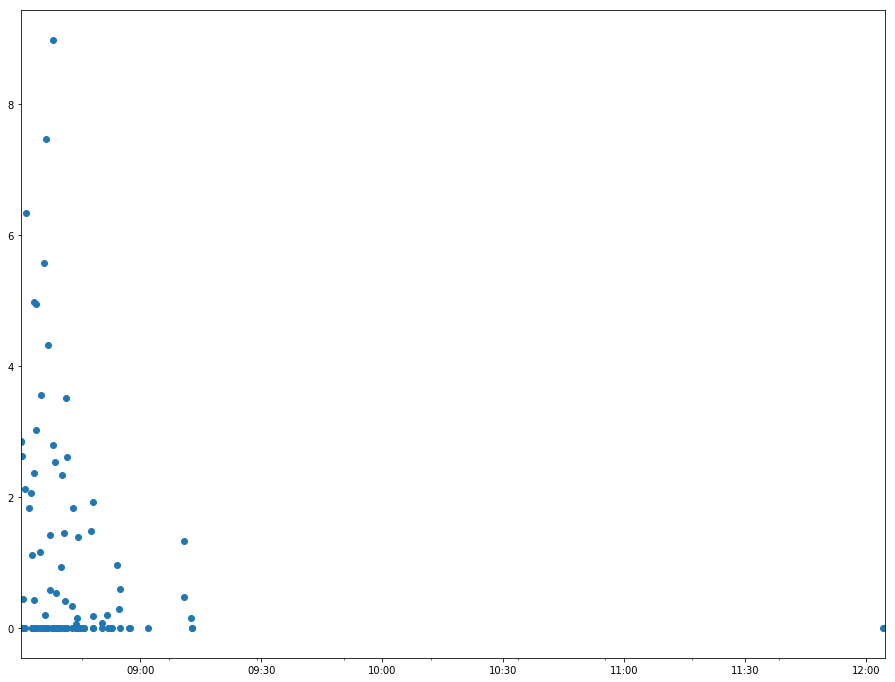

In [15]:
sz=len(dfmain["wait_time"])#this data is timedelta.
for i in range(sz):
    if dfmain.iloc[i,1] == 0:
        dfmain.iloc[i,1] = int(0)
    else:
        formattedtime = dfmain.iloc[i,1].total_seconds()#gives me timedelta as seconds
        dfmain.iloc[i,1] = float(formattedtime)/60
dfmain = dfmain.set_index("initial_time")

fig = plt.figure(figsize=(12,9))
ax = fig.add_axes([0,0,1,1])
ax.scatter(dfmain.index.values,dfmain["wait_time"])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(MaxNLocator(integer=True))
ax.set_xlim(dfmain.index.values.min(),dfmain.index.values.max())

Text(0, 0.5, 'Count')

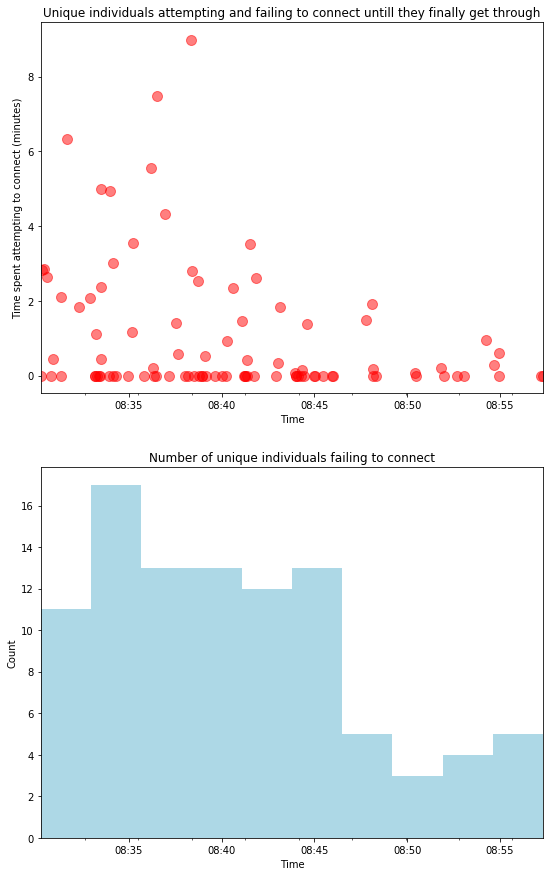

In [16]:
#LOOK AT THE ABOVE GRAPH. It gives us INSIGHT into what range we want to plot.
#It shows which infomation is more useful. now set your custom endtime_limit on the x axis
custom_endtime = "09:00" #hh:mm - make sure it is within range of the data

date = str(dfmain.index.values[2])
npdt_usrlim = np.datetime64(date[0:10]+"T"+str(custom_endtime))
dfmain=dfmain[dfmain.index.values < npdt_usrlim]
                   
                     
#Make the plot again but with our custom endtime to make better sense of the data. 
fig = plt.figure(figsize=(9,15))
ax = fig.add_subplot(2,1,1)
axhis = fig.add_subplot(2,1,2)
ax.scatter(dfmain.index.values,dfmain["wait_time"],s=100,color="red",alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(MaxNLocator(integer=True))
ax.set_xlim(dfmain.index.values.min(),dfmain.index.values.max())
ax.set_title("Unique individuals attempting and failing to connect untill they finally get through")
ax.set_xlabel("Time")
ax.set_ylabel("Time spent attempting to connect (minutes)")

axhis.hist(dfmain.index.values,bins=10,color="lightblue")
axhis.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axhis.xaxis.set_minor_locator(MaxNLocator(integer=True))
axhis.set_xlim(dfmain.index.values.min(),dfmain.index.values.max())
axhis.set_title("Number of unique individuals failing to connect")
axhis.set_xlabel("Time")
axhis.set_ylabel("Count")